In [1]:
import os

In [18]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from PIL import ExifTags, Image
import pickle

In [10]:
from utils.transforms import *

In [11]:
import cv2
# from matplotlib import pyplot as plt

import matplotlib.pyplot as plt

In [12]:
def open_image(img_path):
    img = Image.open(img_path)
    print("Size oriignal", img.size)
    try:
        for orientation in ExifTags.TAGS.keys():
            if ExifTags.TAGS[orientation] == "Orientation":
                break

        exif = img._getexif()

        if exif[orientation] == 3:
            img = img.rotate(180, expand=True)
        elif exif[orientation] == 6:
            img = img.rotate(270, expand=True)
        elif exif[orientation] == 8:
            img = img.rotate(90, expand=True)
    except Exception as ex:
        print(ex)
        pass
    return img.convert("RGB")

In [66]:
image = open_image('../inputs/IMG_2656.jpg')

Size oriignal (3024, 4032)
'NoneType' object is not subscriptable


In [130]:
with open('../mask.pickle', 'rb') as handle:
    mask = pickle.load(handle)

In [131]:
cloth_mapping = {
    "top": [
        5,  # upper cloth
        6,  # dress
        7,  # coat
        14,  # left arm
        15,  # right arm
    ],
    "bottom": [
        9,  # pant
        12,  # skirt
        16,  # left leg
        17,  # right leg
    ],
}

def crop_item(
    image,
    mask,
    item_id,
    keep_original_back=False,
    path_background="/home/jt/Self-Correction-Human-Parsing/2021-09-11 11.13.18.jpg",
):
    print("Size croping", image.size)
    mask = np.asarray(mask)
    unique, counts = np.unique(mask, return_counts=True)
    # print(np.asarray((unique, counts)).T)

    item_mask = np.where(np.isin(mask, [item_id]), 1, 0)
    # print(mask)

    x_min = np.argwhere(item_mask == 1).min(axis=0)[1]
    y_min = np.argwhere(item_mask == 1).min(axis=0)[0]
    x_max = np.argwhere(item_mask == 1).max(axis=0)[1]
    y_max = np.argwhere(item_mask == 1).max(axis=0)[0]

    if keep_original_back:
        return image.crop((x_min, y_min, x_max, y_max))

    matte = np.repeat(np.asarray(item_mask)[:, :, None], 3, axis=2)
    if path_background:
        back = Image.open(path_background)
        back = back.resize(image.size)
    else:
        back = Image.new("L", size=image.size, color=(255)).convert("RGB")
    foreground = image * matte + back * (1 - matte)
    return Image.fromarray(np.uint8(foreground)).crop((x_min, y_min, x_max, y_max))

In [132]:
mask_array = np.asarray(mask)
unique, counts = np.unique(mask_array, return_counts=True)
# print(np.asarray((unique, counts)).T)

item_mask = np.where(np.isin(mask_array, [[
        9,  # pant
        12,  # skirt
        16,  # left leg
        17,  # right leg
    ]]), 1, 0)

x_min = np.argwhere(item_mask == 1).min(axis=0)[1]
y_min = np.argwhere(item_mask == 1).min(axis=0)[0]
x_max = np.argwhere(item_mask == 1).max(axis=0)[1]
y_max = np.argwhere(item_mask == 1).max(axis=0)[0]
print((x_min, y_min, x_max, y_max))

(1484, 1990, 2177, 3197)


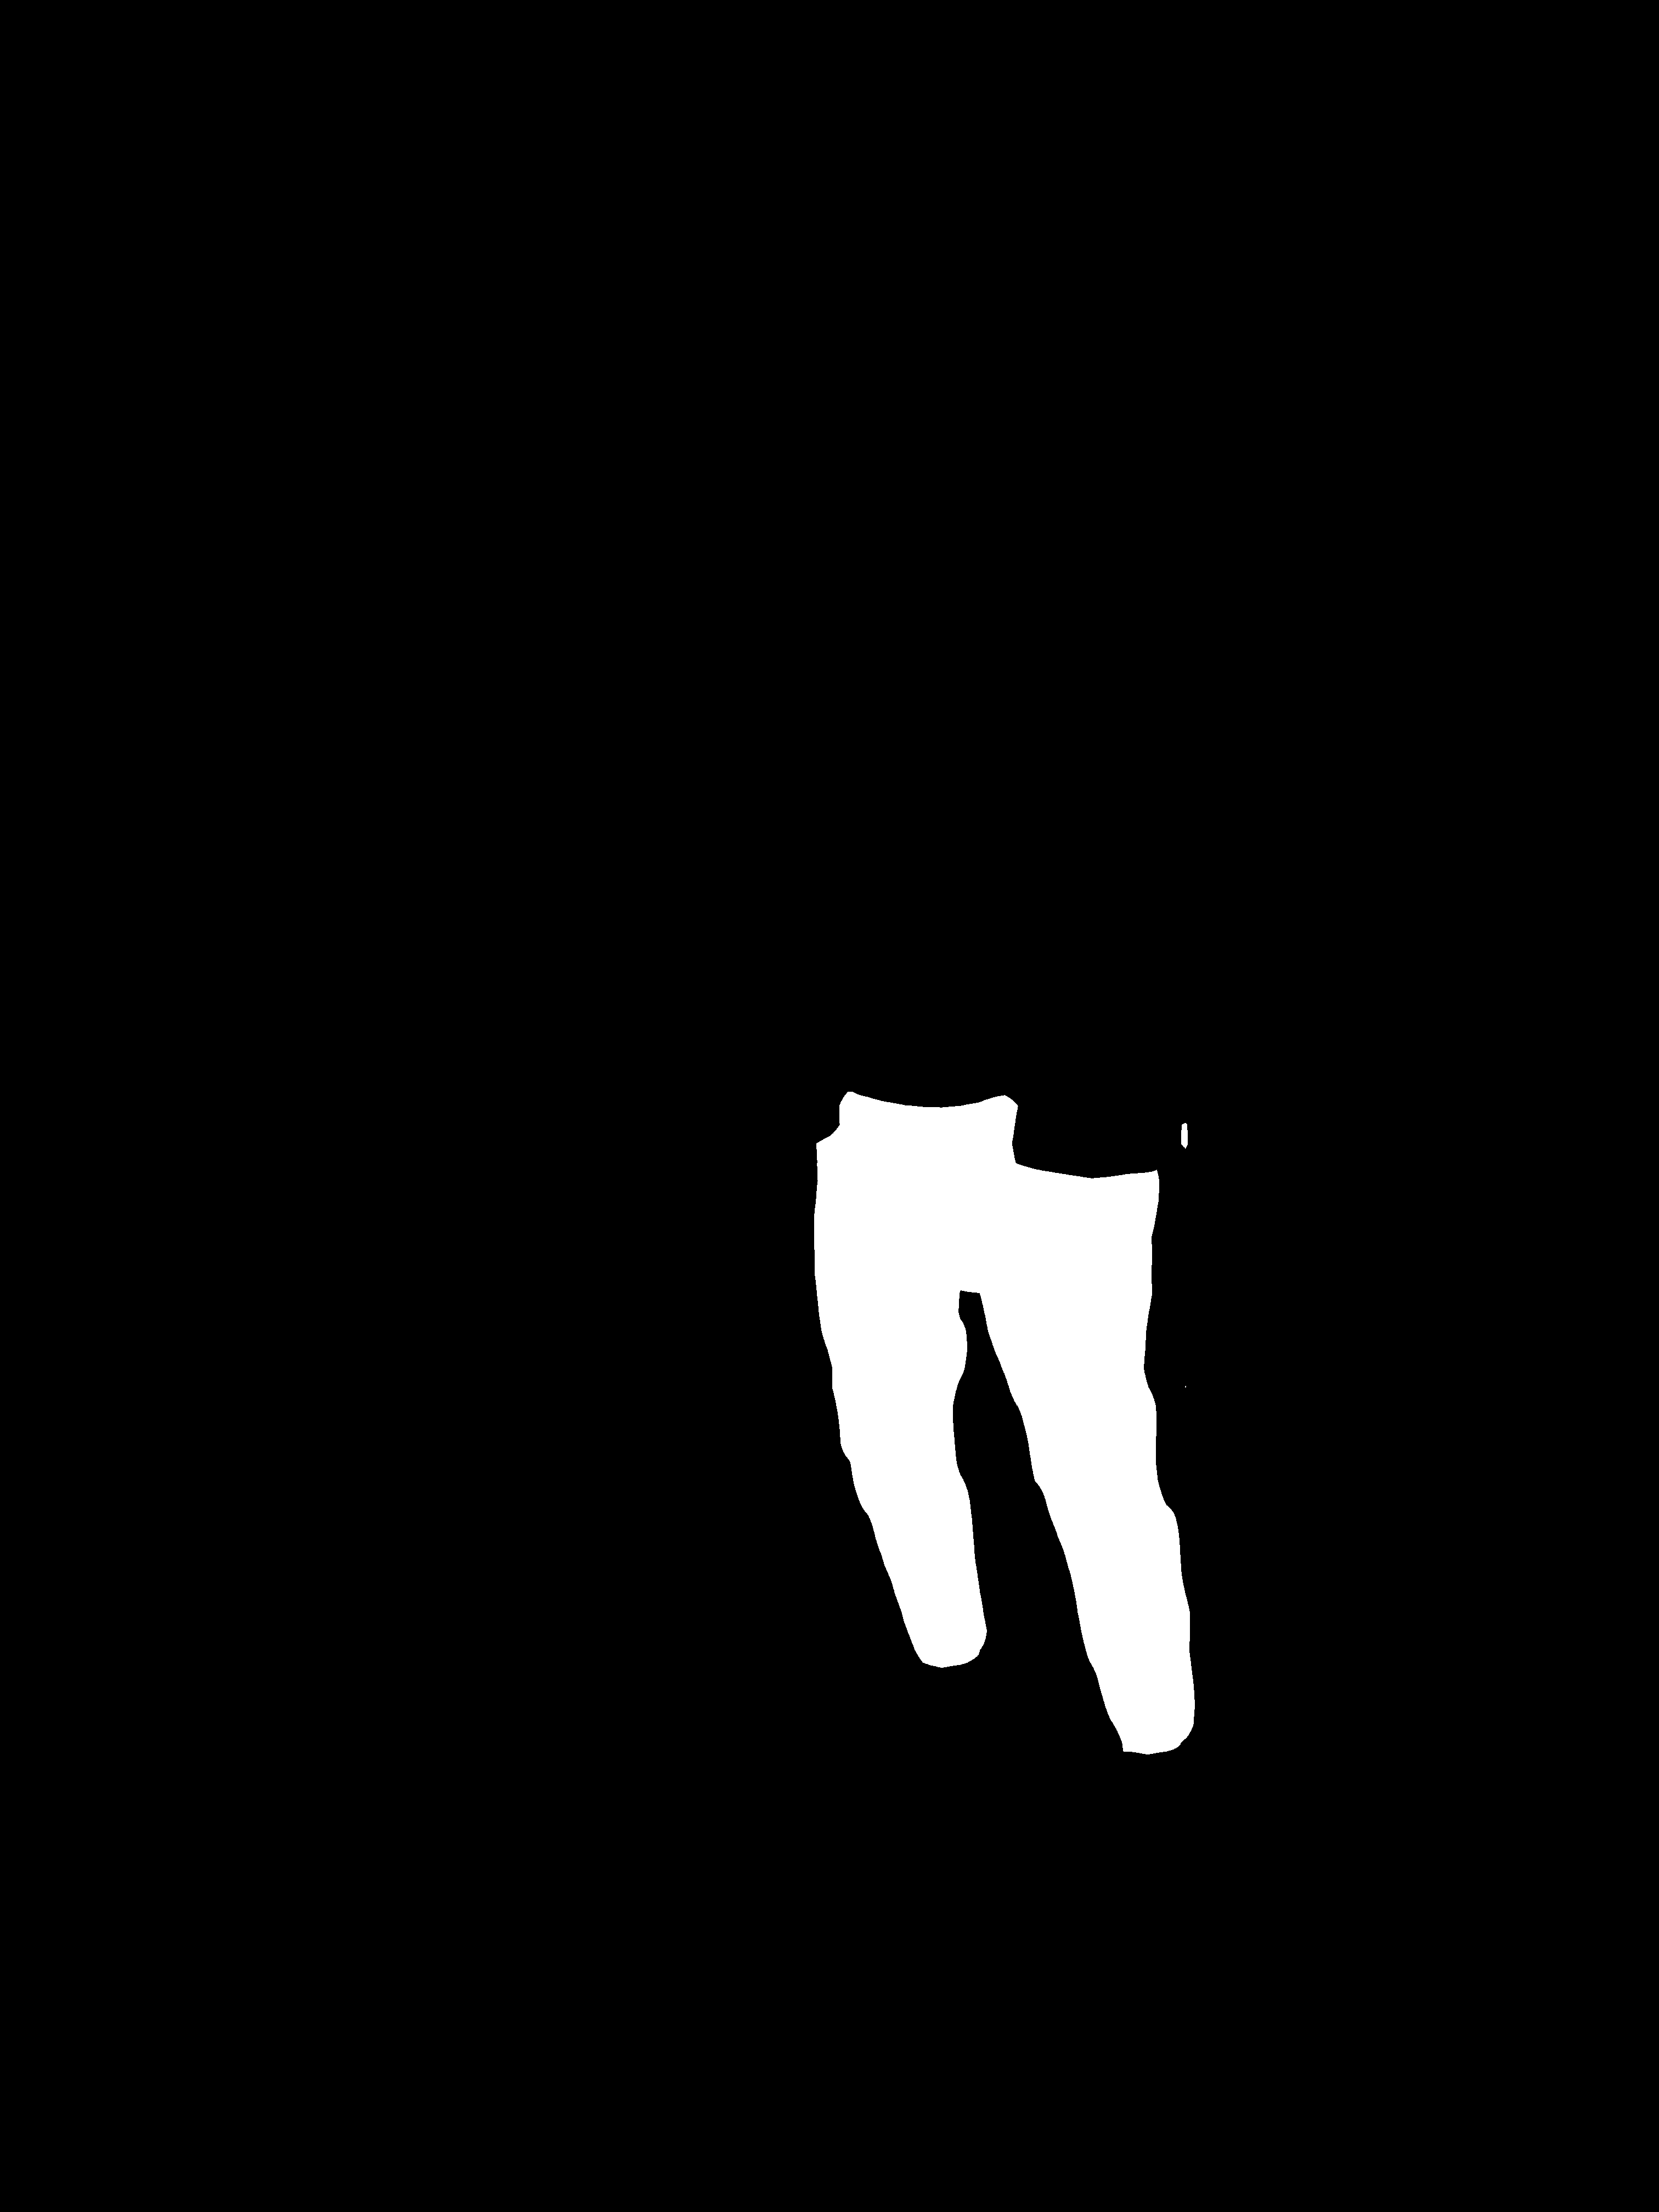

In [133]:
Image.fromarray(np.uint8(item_mask*255))

In [134]:
gray = np.uint8(item_mask*255)

In [135]:
th = cv2.threshold(gray, 0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

In [136]:
# finding contours
contours, hierarchy = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

In [147]:
c = max(contours, key = cv2.contourArea)

In [165]:
contours

[array([[[2161, 2526]],
 
        [[2160, 2527]],
 
        [[2160, 2528]],
 
        [[2161, 2528]],
 
        [[2161, 2527]]], dtype=int32),
 array([[[2159, 2047]],
 
        [[2158, 2048]],
 
        [[2157, 2048]],
 
        [[2156, 2049]],
 
        [[2155, 2049]],
 
        [[2154, 2050]],
 
        [[2154, 2051]],
 
        [[2154, 2052]],
 
        [[2154, 2053]],
 
        [[2154, 2054]],
 
        [[2154, 2055]],
 
        [[2154, 2056]],
 
        [[2154, 2057]],
 
        [[2154, 2058]],
 
        [[2154, 2059]],
 
        [[2153, 2060]],
 
        [[2153, 2061]],
 
        [[2153, 2062]],
 
        [[2153, 2063]],
 
        [[2153, 2064]],
 
        [[2153, 2065]],
 
        [[2153, 2066]],
 
        [[2153, 2067]],
 
        [[2153, 2068]],
 
        [[2153, 2069]],
 
        [[2153, 2070]],
 
        [[2153, 2071]],
 
        [[2153, 2072]],
 
        [[2153, 2073]],
 
        [[2153, 2074]],
 
        [[2153, 2075]],
 
        [[2153, 2076]],
 
        [[2153, 2077]],
 

In [167]:
for c in contours:
    print(c.shape)

(5, 1, 2)
(97, 1, 2)
(4513, 1, 2)


In [162]:
c.shape

(4513, 1, 2)

In [170]:
# create a blank mask
mask = np.zeros((image.size[0], image.size[1]), np.uint8)
# draw selected ROI to form the mask
mask = cv2.drawContours(mask,[c],0, 255, -1)

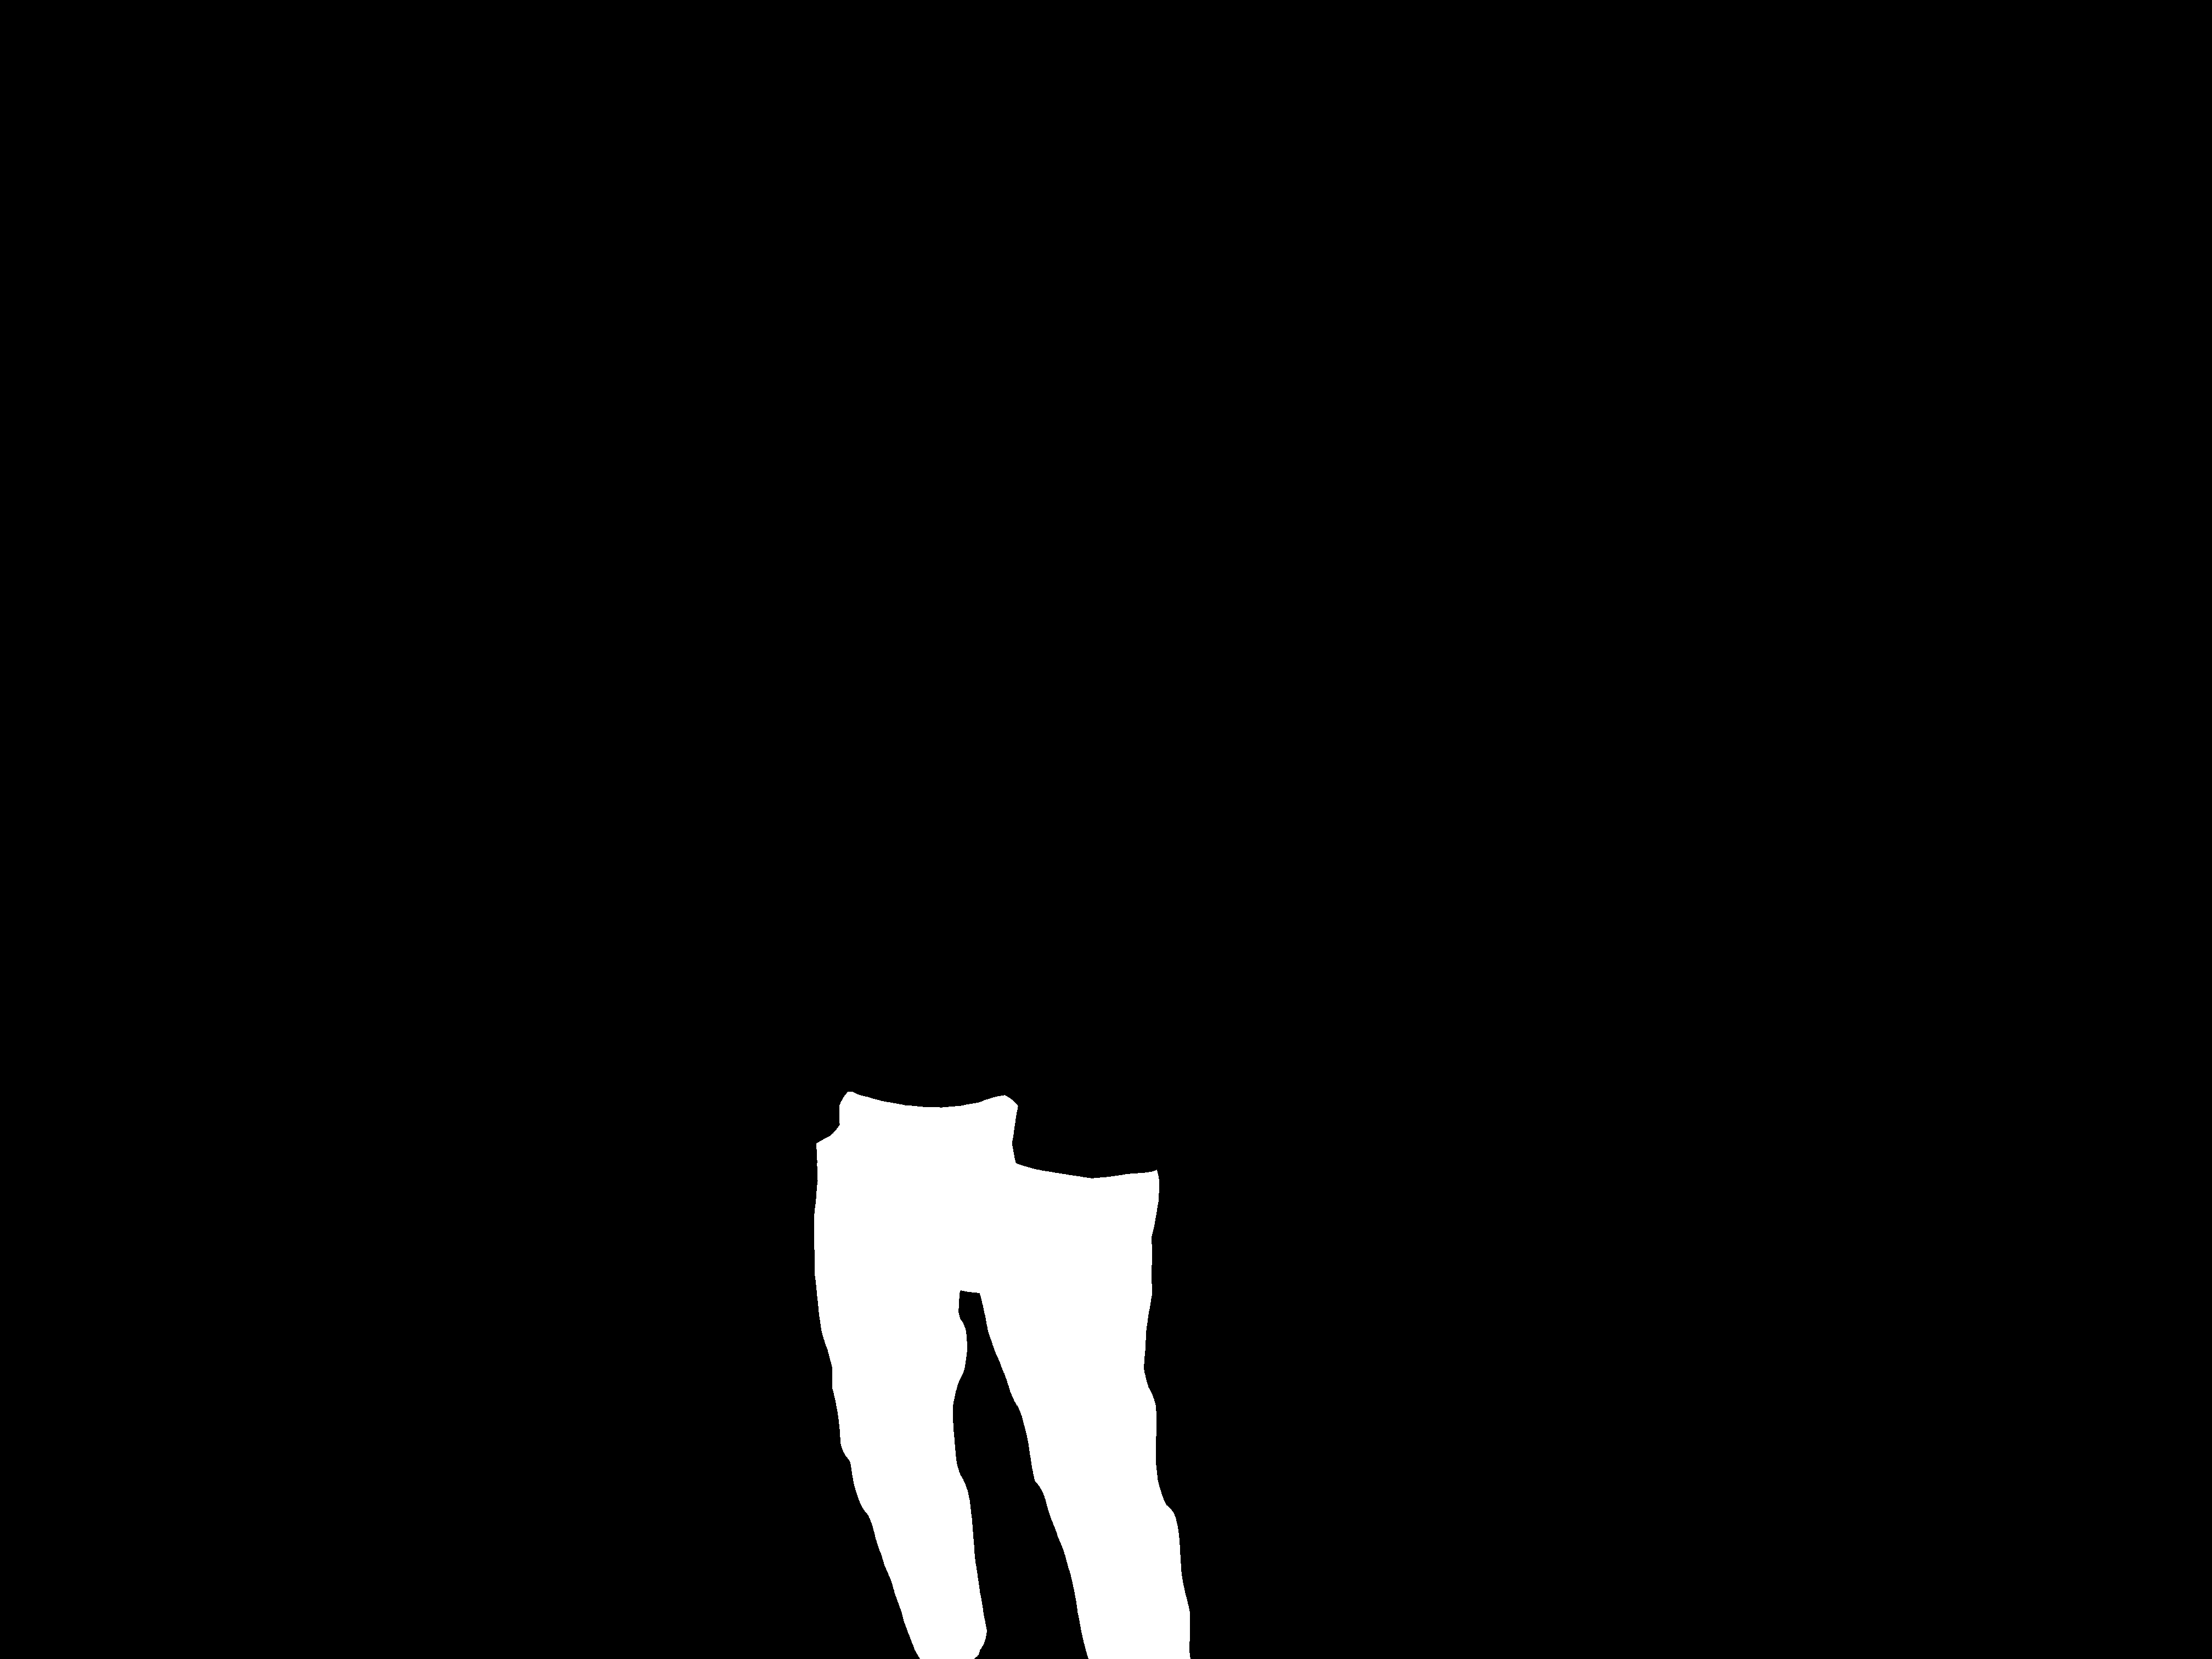

In [171]:
Image.fromarray(np.uint8(mask))

In [125]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10,10))
# dilate_th = cv2.dilate(th, kernel, iterations=3)
dilate_mask = cv2.dilate(mask, kernel, iterations=4)

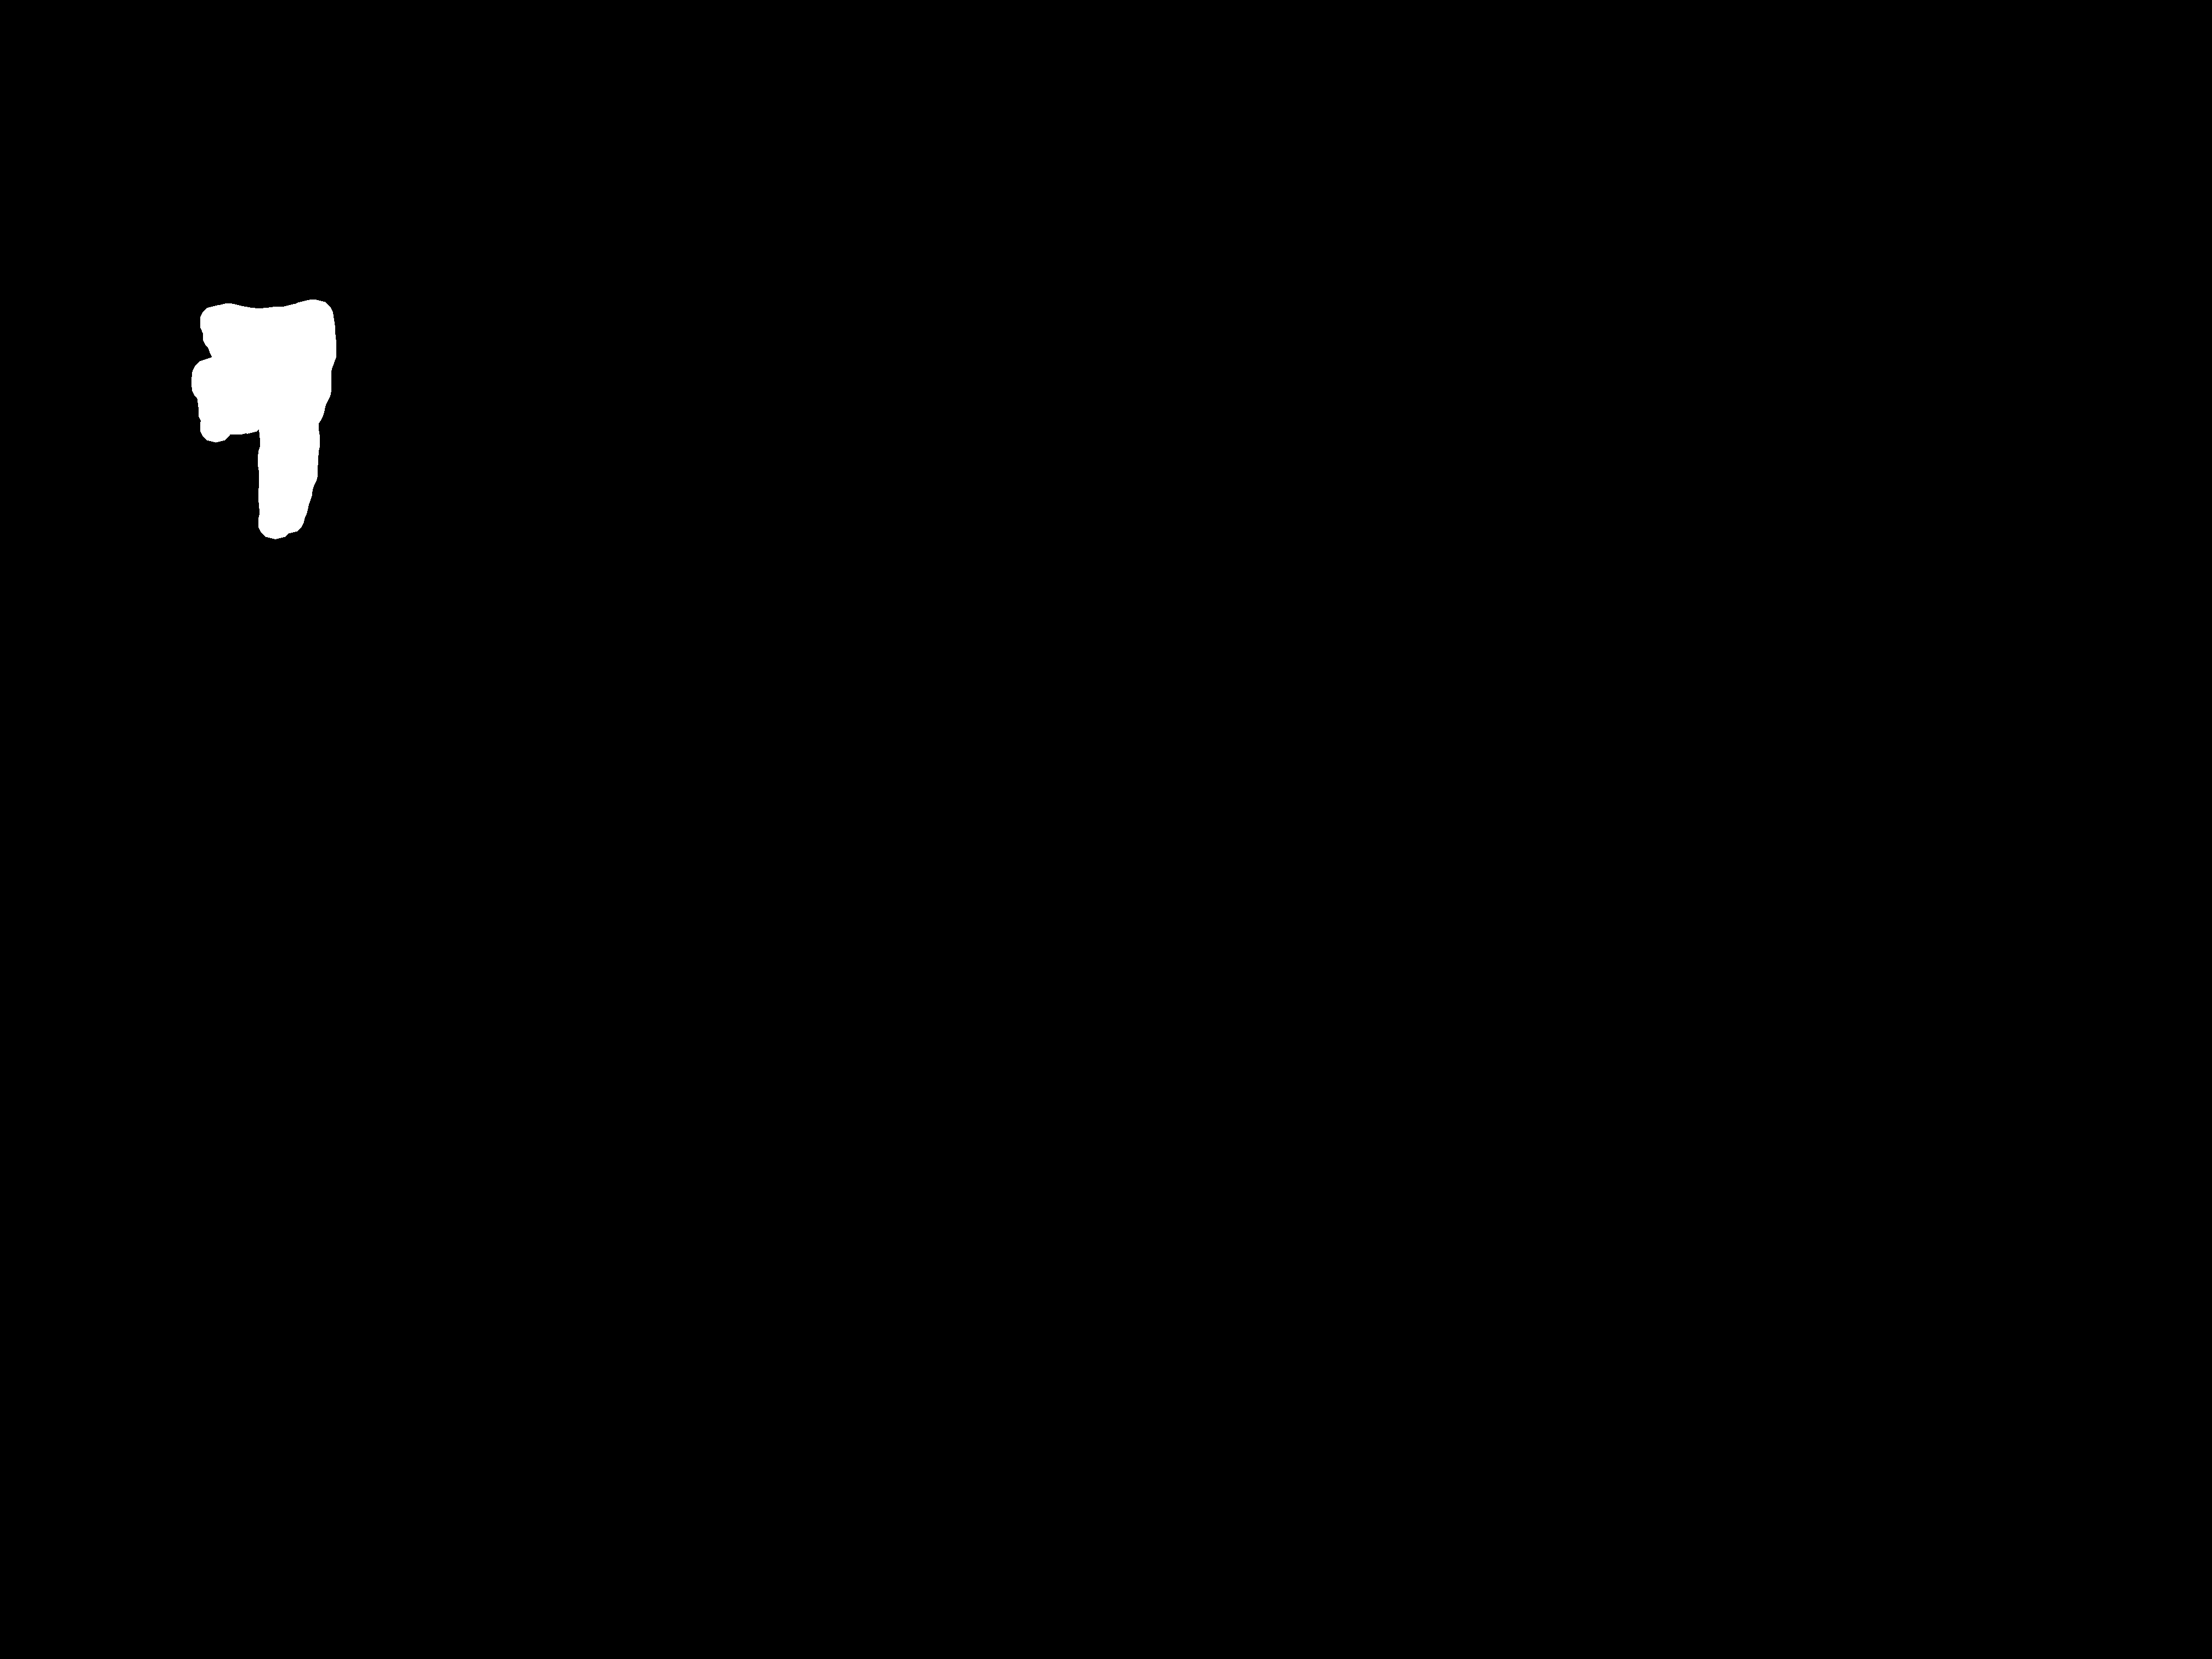

In [127]:
Image.fromarray(np.uint8(dilate_mask))

In [32]:
top = crop_item(image, mask, cloth_mapping["top"])

Size croping (3024, 4032)


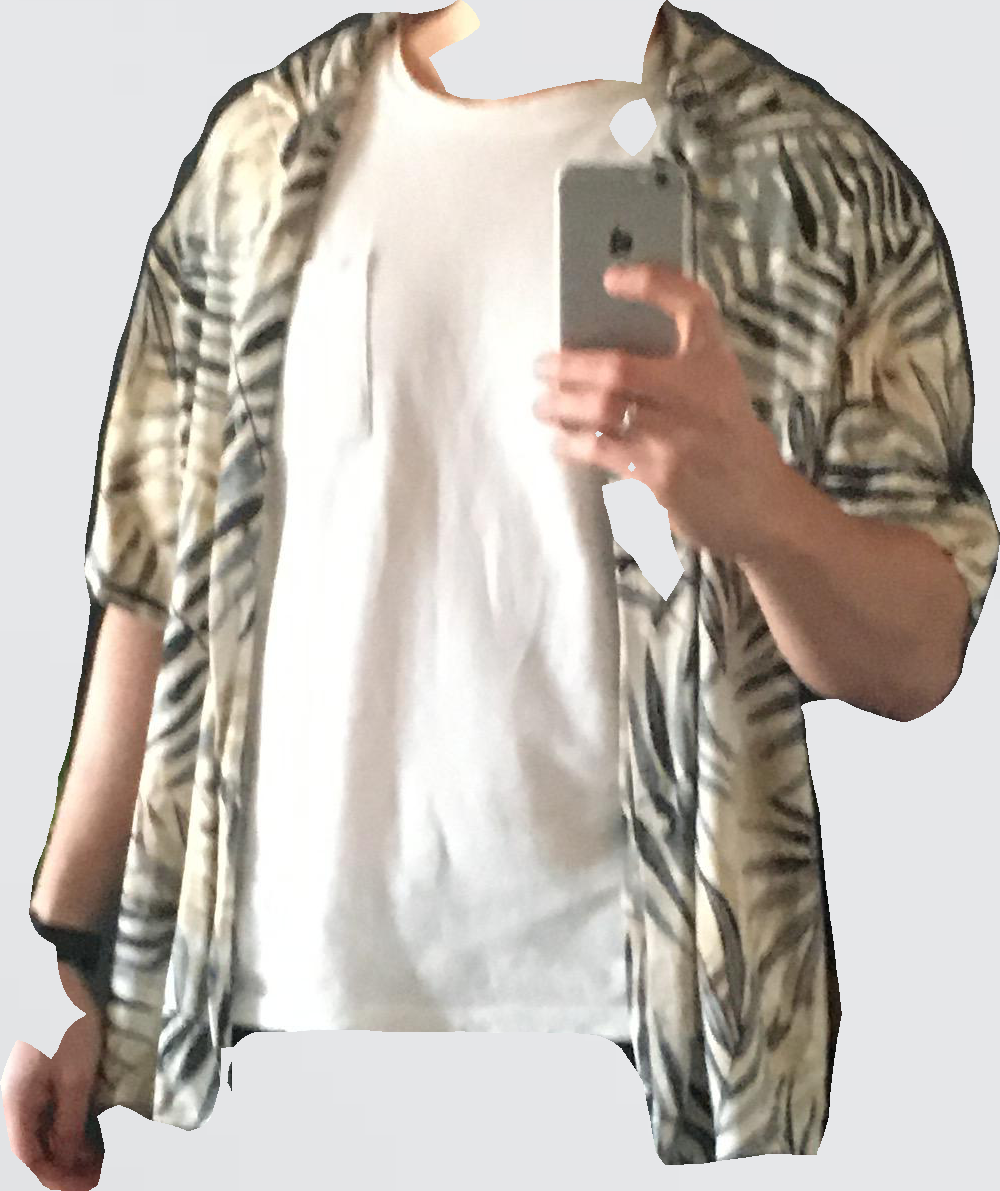

In [33]:
top

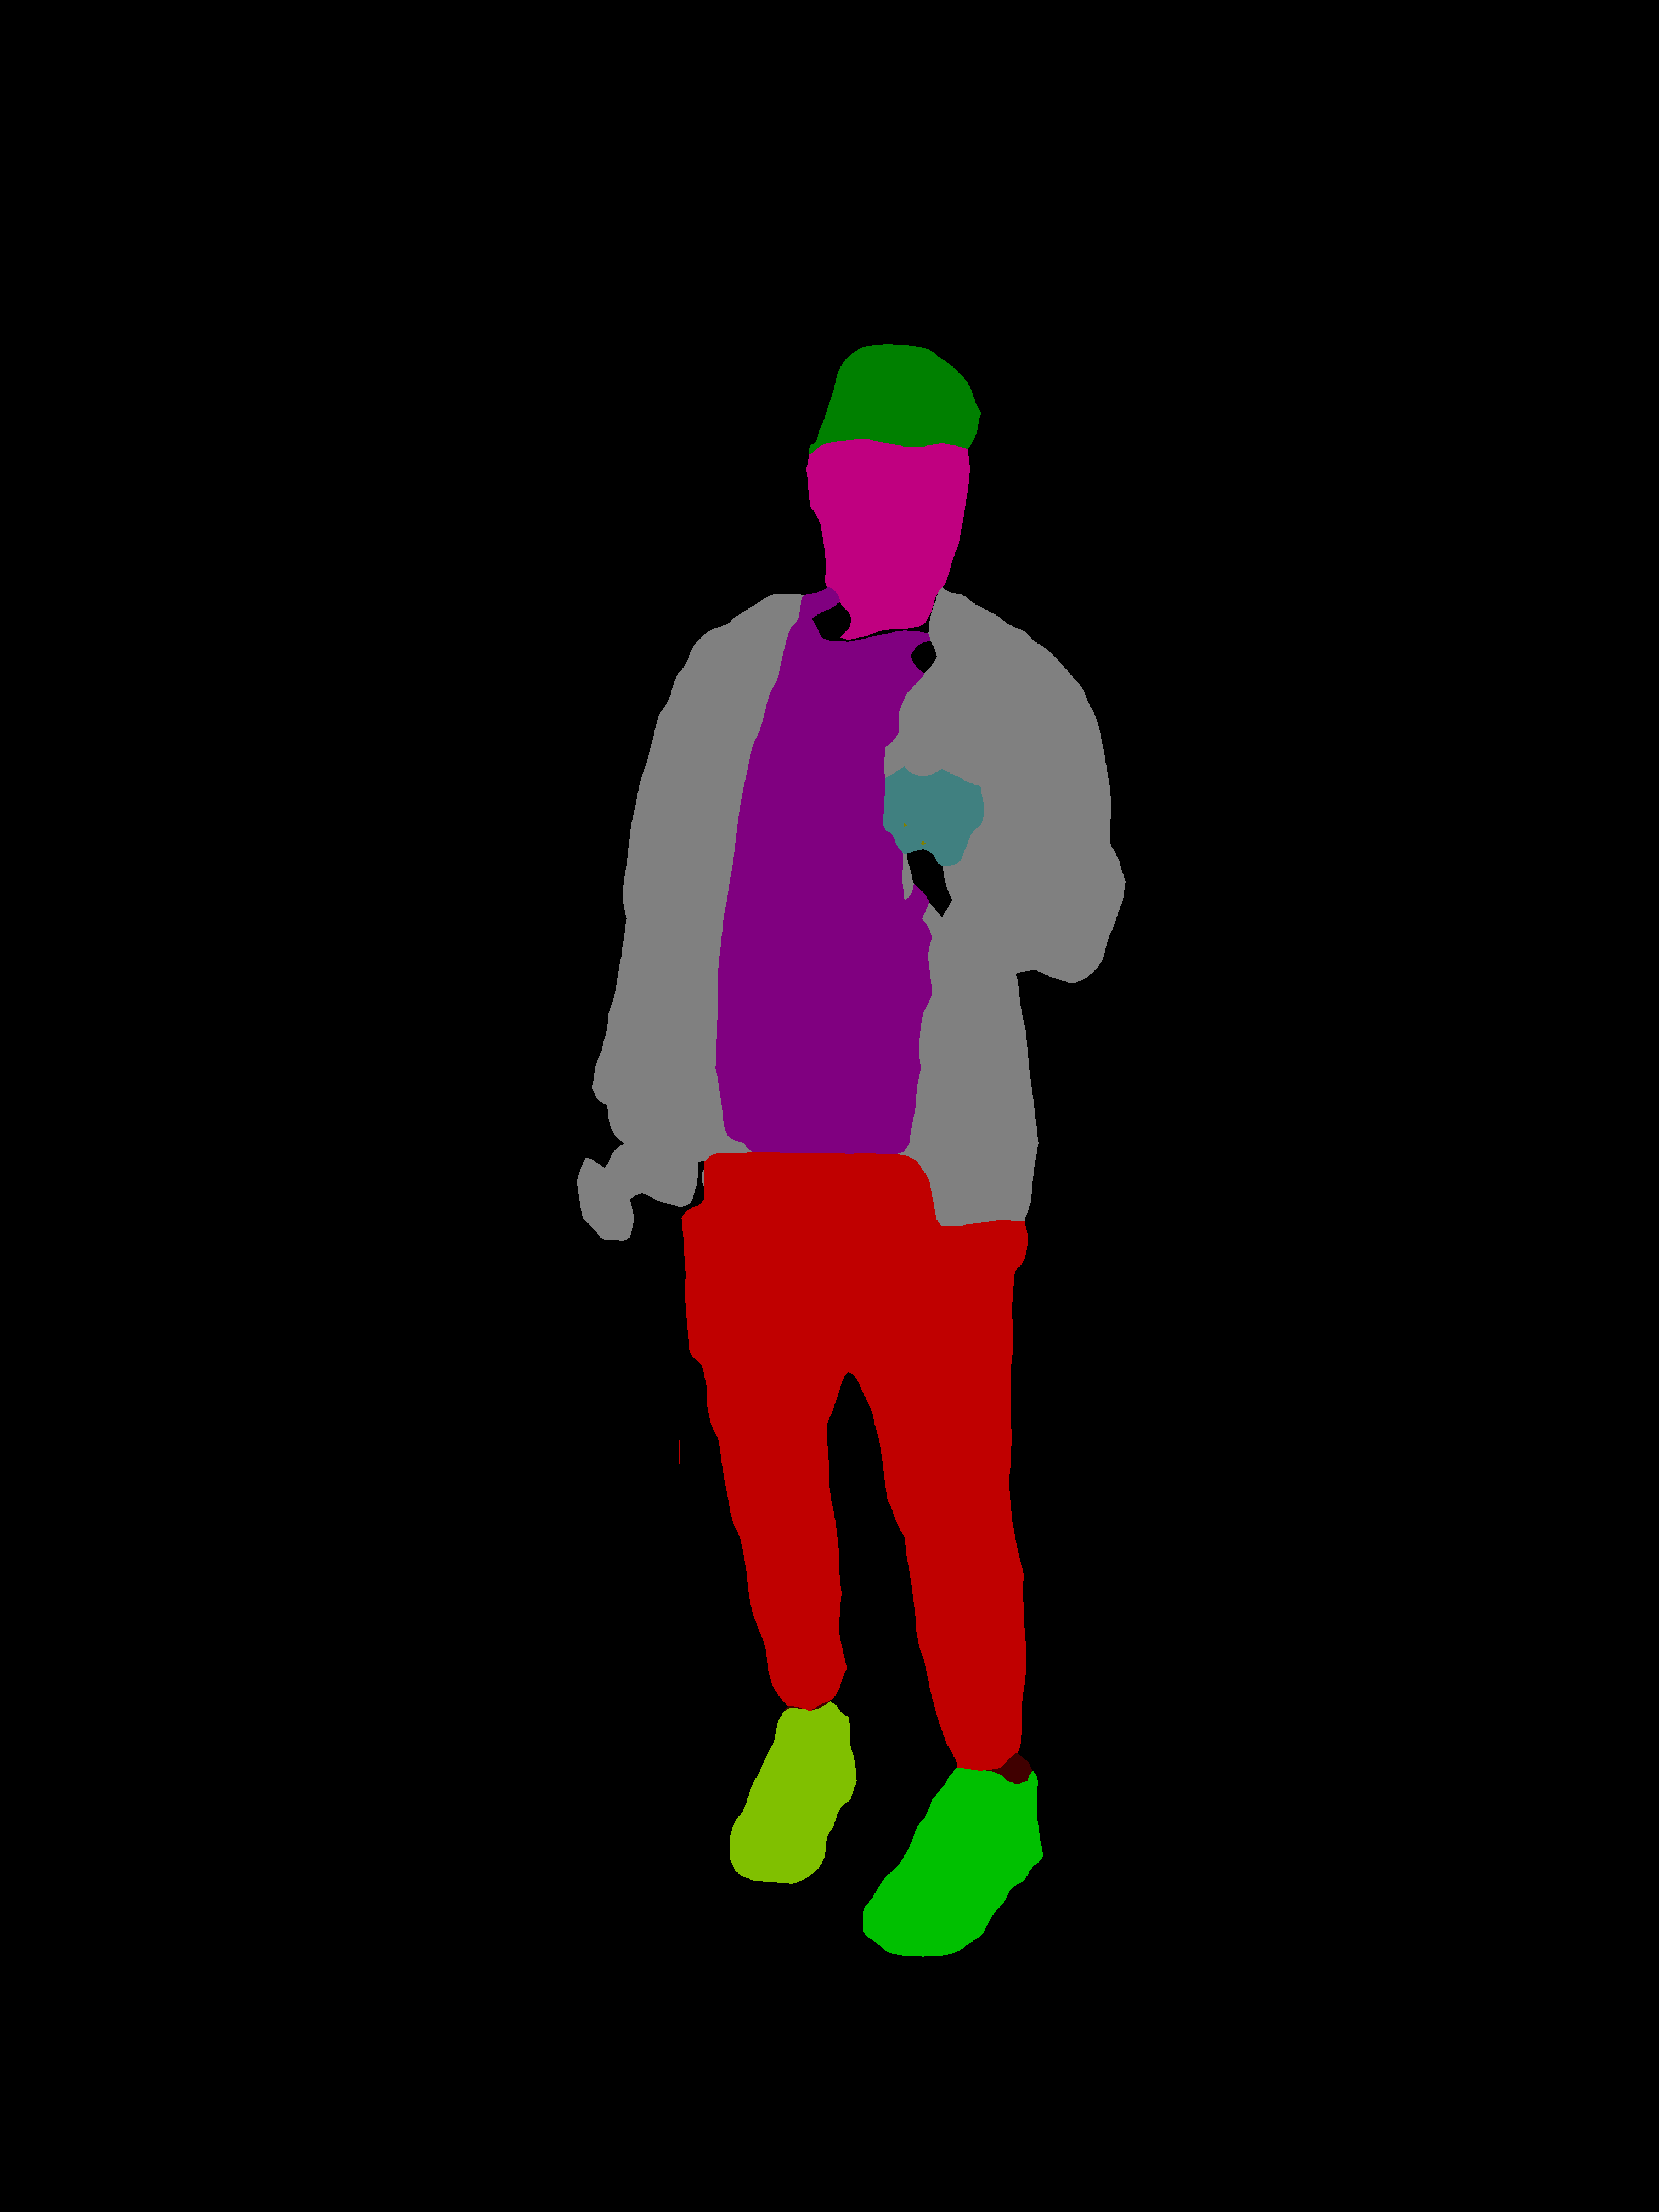

In [26]:
mask

In [25]:
image.size

(3024, 4032)

In [6]:
# img = cv2.imread('../inputs/IMG_2658.jpg', cv2.IMREAD_COLOR)
img = cv2.imread('../inputs/IMG_2656.jpg', cv2.IMREAD_COLOR)
img.shape

(4032, 3024, 3)

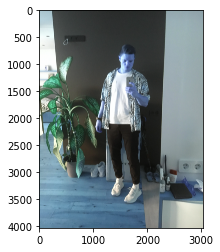

In [7]:
plt.imshow(img, )
plt.show()

In [69]:
input_size = [473, 473]
aspect_ratio = input_size[1] * 1.0 / input_size[0]
h, w, _ = img.shape

# Get person center and scale
def _box2cs(box):
    x, y, w, h = box[:4]
    return _xywh2cs(x, y, w, h)

def _xywh2cs(x, y, w, h):
        center = np.zeros((2), dtype=np.float32)
        center[0] = x + w * 0.5
        center[1] = y + h * 0.5
        if w > aspect_ratio * h:
            h = w * 1.0 / aspect_ratio
        elif w < aspect_ratio * h:
            w = h * aspect_ratio
        scale = np.array([w, h], dtype=np.float32)
        return center, scale
    
person_center, s = _box2cs([0, 0, w - 1, h - 1])
r = 0
trans = get_affine_transform(person_center, s, r, input_size)

In [70]:
input = cv2.warpAffine(
            img,
            trans,
            (int(input_size[1]), int(input_size[0])),
            flags=cv2.INTER_LINEAR,
            borderMode=cv2.BORDER_CONSTANT,
            borderValue=(0, 0, 0))

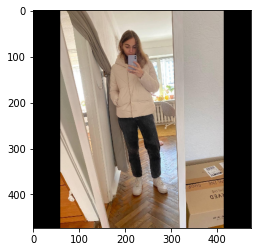

In [71]:
plt.imshow(input[:,:,::-1])
plt.show()

In [72]:
meta = {
    'center': person_center,
    'height': h,
    'width': w,
    'scale': s,
    'rotation': r
}
meta

{'center': array([479.5, 639.5], dtype=float32),
 'height': 1280,
 'width': 960,
 'scale': array([1279., 1279.], dtype=float32),
 'rotation': 0}

In [73]:
import argparse
import os

import numpy as np
import torch
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import DataLoader
from tqdm import tqdm

import networks
from datasets.simple_extractor_dataset import SimpleFolderDataset
from utils.transforms import transform_logits

def get_palette(num_cls):
    """Returns the color map for visualizing the segmentation mask.
    Args:
        num_cls: Number of classes
    Returns:
        The color map
    """
    n = num_cls
    palette = [0] * (n * 3)
    for j in range(0, n):
        lab = j
        palette[j * 3 + 0] = 0
        palette[j * 3 + 1] = 0
        palette[j * 3 + 2] = 0
        i = 0
        while lab:
            palette[j * 3 + 0] |= ((lab >> 0) & 1) << (7 - i)
            palette[j * 3 + 1] |= ((lab >> 1) & 1) << (7 - i)
            palette[j * 3 + 2] |= ((lab >> 2) & 1) << (7 - i)
            i += 1
            lab >>= 3
    return palette

In [74]:
transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize(mean=[0.406, 0.456, 0.485], std=[0.225, 0.224, 0.229])]
    )

upsample = torch.nn.Upsample(size=input_size, mode="bilinear", align_corners=True)

In [77]:
num_classes = 20
model = networks.init_model("resnet101", num_classes=num_classes, pretrained=None)
palette = get_palette(num_classes)

In [78]:
state_dict = torch.load("../checkpoints/final.pth")["state_dict"]
from collections import OrderedDict

new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:]  # remove `module.`
    new_state_dict[name] = v
model.load_state_dict(new_state_dict)
model.cuda()
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): InPlaceABNSync(64, eps=1e-05, momentum=0.1, affine=True, activation=none)
  (relu1): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): InPlaceABNSync(64, eps=1e-05, momentum=0.1, affine=True, activation=none)
  (relu2): ReLU()
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): InPlaceABNSync(128, eps=1e-05, momentum=0.1, affine=True, activation=none)
  (relu3): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): InPlaceABNSync(64, eps=1e-05, momentum=0.1, affine=True, activation=none)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): InPlaceABNSync(64

In [79]:
image = transform(input)
output = model(image.unsqueeze(0).cuda())

In [80]:
upsample_output = upsample(output[0][-1][0].unsqueeze(0))
upsample_output = upsample_output.squeeze()
upsample_output = upsample_output.permute(1, 2, 0)  # CHW -> HWC

logits_result = transform_logits(upsample_output.data.cpu().numpy(), person_center, s, w, h, input_size=input_size)
parsing_result = np.argmax(logits_result, axis=2)
# parsing_result_path = os.path.join(args.output_dir, img_name[:-4] + ".png")
output_img = Image.fromarray(np.asarray(parsing_result, dtype=np.uint8))
output_img.putpalette(palette)

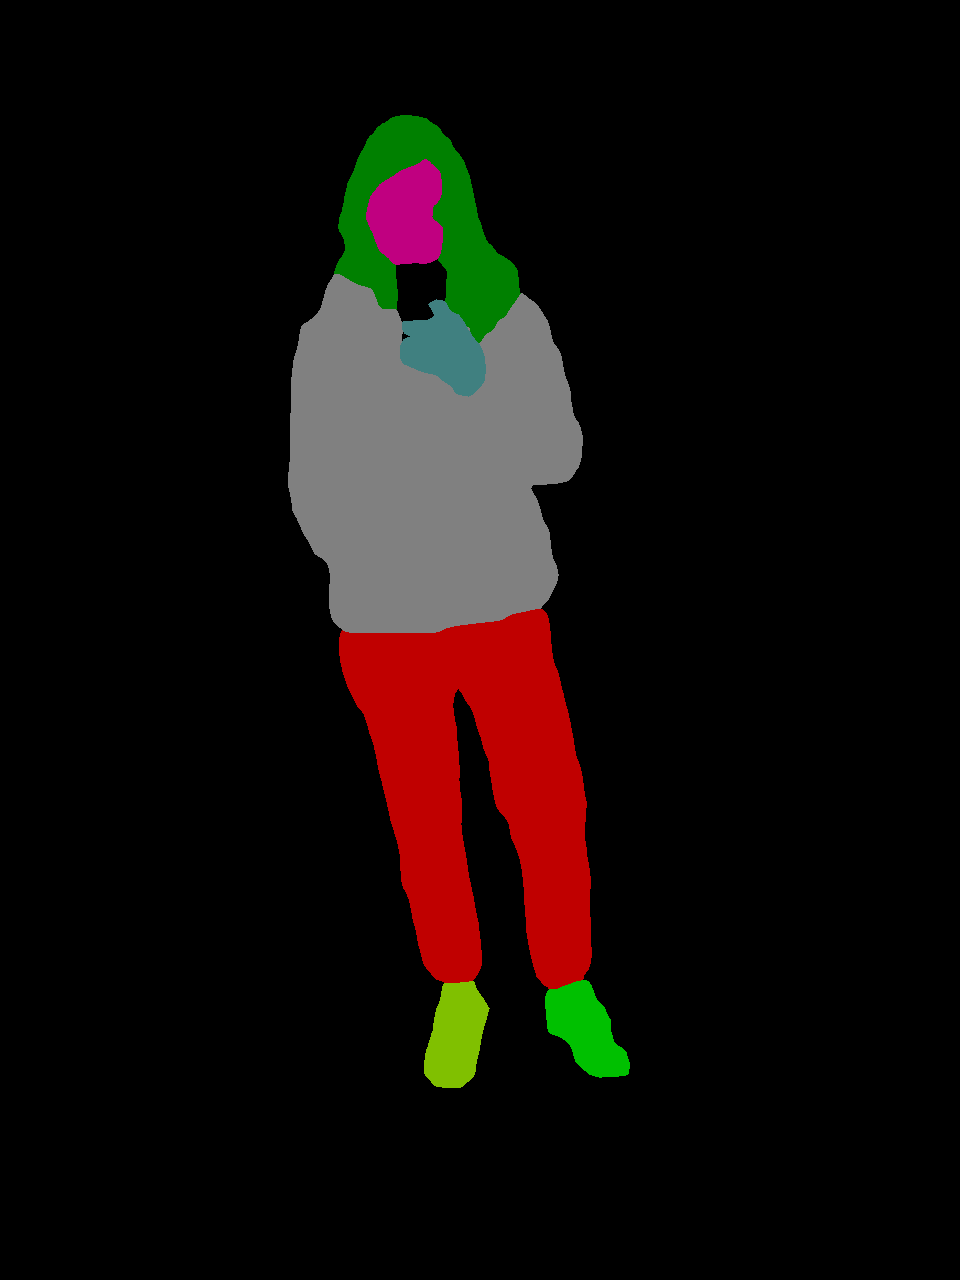

In [81]:
output_img